In [11]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model
import numpy as np
import tensorflow as tf
import os
import re
import matplotlib.pyplot as plt

file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')

lines = lines[['eng', 'fra']][:33000] # 3.3만개 샘플 사용
print('전체 샘플의 수 :',len(lines))
lines.sample(5)
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')

전체 샘플의 수 : 33000


## Preprocessing

In [4]:
# 구두점과 단어 분리, 소문자로 변환, 띄어쓰기 단위로 토큰화 수행.

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = sentence.split(" ")
    
    return sentence


def preprocess_sentence_decoder(sentence):
    sentence = sentence.lower().strip()
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = ' ' + sentence + ' '
    sentence = sentence.split(" ")
    
    return sentence


lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))
lines.fra = lines.fra.apply(lambda x : preprocess_sentence_decoder(x))

# 토큰화
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(lines.eng)
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(lines.fra)
target_text = fra_tokenizer.texts_to_sequences(lines.fra)


In [5]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 단어장의 크기 : 4671
프랑스어 단어장의 크기 : 7453
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [6]:
# For Teacher Forcing
sos_token = ''
eos_token = ''
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]


# padding
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')


# train / Validation split
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

## Training

In [7]:
encoder_inputs = Input(shape=(None,))
# encoder embedding
enc_emb = Embedding(eng_vocab_size, 256, input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(units = 256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
# decoder embedding
dec_emb = Embedding(fra_vocab_size, 256)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=['acc'])
model_history = model.fit([encoder_input_train, decoder_input_train],decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 32, epochs = 50)



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1195776     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    1907968     input_2[0][0]                    
______________________________________________________________________________________________

938/938 [==============================] - 15s 16ms/step - loss: 0.0839 - acc: 0.9897 - val_loss: 0.1171 - val_acc: 0.9867
Epoch 44/50
938/938 [==============================] - 15s 16ms/step - loss: 0.0835 - acc: 0.9897 - val_loss: 0.1168 - val_acc: 0.9867
Epoch 45/50
938/938 [==============================] - 16s 17ms/step - loss: 0.0834 - acc: 0.9897 - val_loss: 0.1168 - val_acc: 0.9867
Epoch 46/50
938/938 [==============================] - 15s 16ms/step - loss: 0.0833 - acc: 0.9897 - val_loss: 0.1166 - val_acc: 0.9867
Epoch 47/50
938/938 [==============================] - 15s 16ms/step - loss: 0.0830 - acc: 0.9897 - val_loss: 0.1163 - val_acc: 0.9867
Epoch 48/50
938/938 [==============================] - 15s 16ms/step - loss: 0.0828 - acc: 0.9898 - val_loss: 0.1166 - val_acc: 0.9867
Epoch 49/50
938/938 [==============================] - 15s 16ms/step - loss: 0.0829 - acc: 0.9898 - val_loss: 0.1166 - val_acc: 0.9867
Epoch 50/50
938/938 [==============================] - 15s 16ms/ste

## Visualization

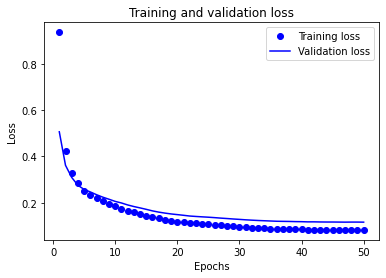

In [12]:
LSTM_history_dict = model_history.history
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Test

In [13]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dec_emb2 = Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()


eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word


def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['']) and i!=fra2idx['']):
            temp = temp + idx2fra[i] + ' '
    return temp


for seq_index in [1,100,301,777,2222]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         1195776   
_________________________________________________________________
masking (Masking)            (None, None, 256)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 1,721,088
Trainable params: 1,721,088
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            

### 회고
번역기가 완성되었지만, 무슨 일인지 번역기가 번역한 문장은 형편없었다. 마지막 프랑스어를 번역한 문장은 프랑스어로 '나는 우리 텍스트를 더럽힌다'라는 뜻이라고 한다. 그럼에도 불구하고 accuracy는 꽤 높은 수치로 나왔다. accuracy가 높다 라는 건 어느정도 번역의 수준이 잘되었다는 뜻같은데, 왜 이정도로 형편없는 번역이 나왔는지 알고싶다.